In [1]:
# Common imports
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images",)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

#### Load data

In [2]:
def load_data():
    data = pd.read_csv('spill_incidents_sample.csv')
    return data

#### Create target variable
- The dataset has a column “recovered”. Recovered can be greater than 0(YES) or equals to 0 (NO).

In [3]:
def transform_target(df):
    df['recovered'] = df['recovered'].apply(lambda x:'YES' if x >0 else 'NO')
    return df

data = load_data()
data = transform_target(data)
data.drop('Unnamed: 0', axis=1, inplace=True)
data.to_csv('spill_incidents_sample_with_target.csv', index=False)


#### Data overview

In [4]:
data.tail(3)

,spill_number,program_facility_name,street_1,street_2,locality,county,zip_code,swis_code,dec_region,spill_date,received_date,contributing_factor,waterbody,source,close_date,material_name,material_family,quantity,units,recovered
187666,9707739,KIKARI DENTAL RT 30 AGWAY,4340 RT 30 NORTH,NaN,AMSTERDAM,Montgomery,NaN,2920,4,1997-09-30,1997-09-30,Tank Overfill,NaN,Tank Truck,1997-10-03,#2 fuel oil,Petroleum,0.0,Gallons,NO
187667,1209420,POLE TOP,29 QUARRY LANE,NaN,BEDFORD,Westchester,NaN,6020,3,2012-11-06,2012-11-06,Storm,NaN,Transformer,2012-11-09,dielectric fluid,Petroleum,10.0,Gallons,NO
187668,900797,CUMBERLAND FARMS #3141 RT 9 @ BOGHT RD LOUDON RD,1093 LOUDON RD RT 9 @ BOGHT RD,CUMBERLAND FARMS # 3141 1093 LOUDON RD,COHOES COLONIE,Albany,NaN,126,4,2009-04-21,2009-04-21,Other,NaN,Gasoline Station or other PBS Facility,2009-05-08,other - WATER,Other,0.0,Gallons,NO


In [50]:
data.dtypes

spill_number               int64
program_facility_name     object
street_1                  object
street_2                  object
locality                  object
county                    object
zip_code                  object
swis_code                  int64
dec_region                 int64
spill_date                object
received_date             object
contributing_factor       object
waterbody                 object
source                    object
close_date                object
material_name             object
material_family           object
quantity                 float64
units                     object
recovered                 object
dtype: object

In [6]:
data.describe()

,spill_number,swis_code,dec_region,quantity
count,1.876690e+05,187669.000000,187669.000000,1.876690e+05
mean,4.442654e+06,3478.814391,3.992956,5.350332e+05
std,4.208655e+06,1717.484381,2.593400,2.308367e+08
min,1.000000e+00,100.000000,1.000000,0.000000e+00
25%,7.069440e+05,2401.000000,2.000000,0.000000e+00
50%,1.511169e+06,3400.000000,3.000000,0.000000e+00
75%,9.211040e+06,5200.000000,6.000000,5.000000e+00
max,9.975754e+06,9500.000000,9.000000,1.000000e+11


In [12]:
from prettytable import PrettyTable
x = PrettyTable()

x.field_names = ['Number of Columns','Number of Rows', 'File Size']
x.add_row([data.shape[1], data.shape[0], os.path.getsize('spill_incidents_sample.csv')])
print(x)

+-------------------+----------------+-----------+
| Number of Columns | Number of Rows | File Size |
+-------------------+----------------+-----------+
|         20        |     187669     |  35570195 |
+-------------------+----------------+-----------+


#### Column Type Counts

In [55]:
from dateutil.parser import parse

def check_is_categorical(df, col):
    unique_samples = len(df[col].unique())
    total_samples = df[col].shape[0]
    pct_diff = round((total_samples - unique_samples) / total_samples * 100,2)
#     print(pct_diff)
    if pct_diff <= 94:
        return False # not categorical
    else:
        return True  # categorical
    
def check_is_date(df, col):
    string = df[col].dropna().unique()[0]
    try: 
        parse(string, fuzzy=False)
        return True

    except ValueError:
        return False
    
    
def get_column_type(df):
    types = {'Numeric':len(data.select_dtypes(['int64','float64']).count()), 'Text':0,'Categorical':0, 'Date':0}
    for col in df.columns:
        sample = df[col].dropna().unique()[0]
        if isinstance(sample, str):
            res = check_is_date(df, col)
            if res:
                types['Date'] +=1
            else:
                res = check_is_categorical(df, col)
                if res:
                    types['Categorical'] += 1
                else:
                    types['Text'] += 1
#     print(types)
    return types


x = PrettyTable()

column_type = get_column_type(data)
x.field_names = ['Column type', 'Count']

for k,v in column_type.items():
    x.add_row([k,v])
print(x)

+-------------+-------+
| Column type | Count |
+-------------+-------+
|   Numeric   |   4   |
|     Text    |   3   |
| Categorical |   10  |
|     Date    |   3   |
+-------------+-------+


#### Data completeness

In [56]:
def calc_data_nullity(df):
    df_nullity = df.isnull()
    missing_values_sum = df_nullity.sum()
    missing_values_percent = df_nullity.mean() * 100
    return missing_values_sum, missing_values_percent

missing_values_sum, missing_values_percent = calc_data_nullity(data)


#### Total Missing Values

In [66]:
x = PrettyTable()
print('Total Missing Values')
x.field_names = ['Column', 'Missing values Count']      
for k,v in missing_values_sum.to_dict().items():
    x.add_row([k,v])
print(x)              

Total Missing Values
+-----------------------+----------------------+
|         Column        | Missing values Count |
+-----------------------+----------------------+
|      spill_number     |          0           |
| program_facility_name |          3           |
|        street_1       |          53          |
|        street_2       |        172775        |
|        locality       |         389          |
|         county        |          0           |
|        zip_code       |        171173        |
|       swis_code       |          0           |
|       dec_region      |          0           |
|       spill_date      |          57          |
|     received_date     |          0           |
|  contributing_factor  |          0           |
|       waterbody       |        170995        |
|         source        |          0           |
|       close_date      |         4302         |
|     material_name     |          0           |
|    material_family    |          0           |

#### Percentage of Missing Values

In [68]:
x = PrettyTable()
print('Total Missing Values')
x.field_names = ['Column', 'Missing values Percentage']      
for k,v in missing_values_percent.to_dict().items():
    x.add_row([k,round(v,2)])
print(x)              

Total Missing Values
+-----------------------+---------------------------+
|         Column        | Missing values Percentage |
+-----------------------+---------------------------+
|      spill_number     |            0.0            |
| program_facility_name |            0.0            |
|        street_1       |            0.03           |
|        street_2       |           92.06           |
|        locality       |            0.21           |
|         county        |            0.0            |
|        zip_code       |           91.21           |
|       swis_code       |            0.0            |
|       dec_region      |            0.0            |
|       spill_date      |            0.03           |
|     received_date     |            0.0            |
|  contributing_factor  |            0.0            |
|       waterbody       |           91.12           |
|         source        |            0.0            |
|       close_date      |            2.29           |
|     m

#### Visualize missingness

<AxesSubplot:>

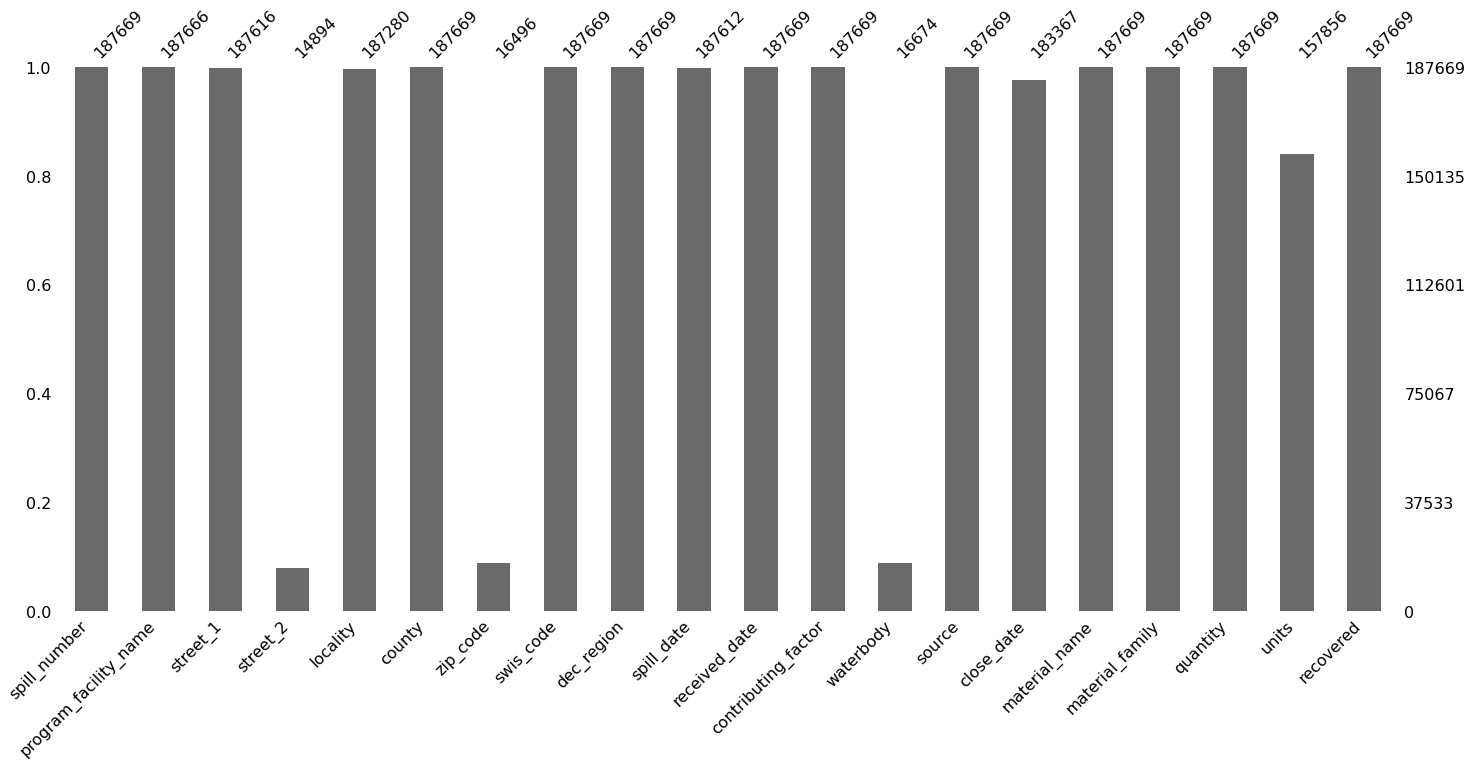

In [70]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline

# Plot amount of missingness
msno.bar(data)

Saving figure attribute_histogram_plots


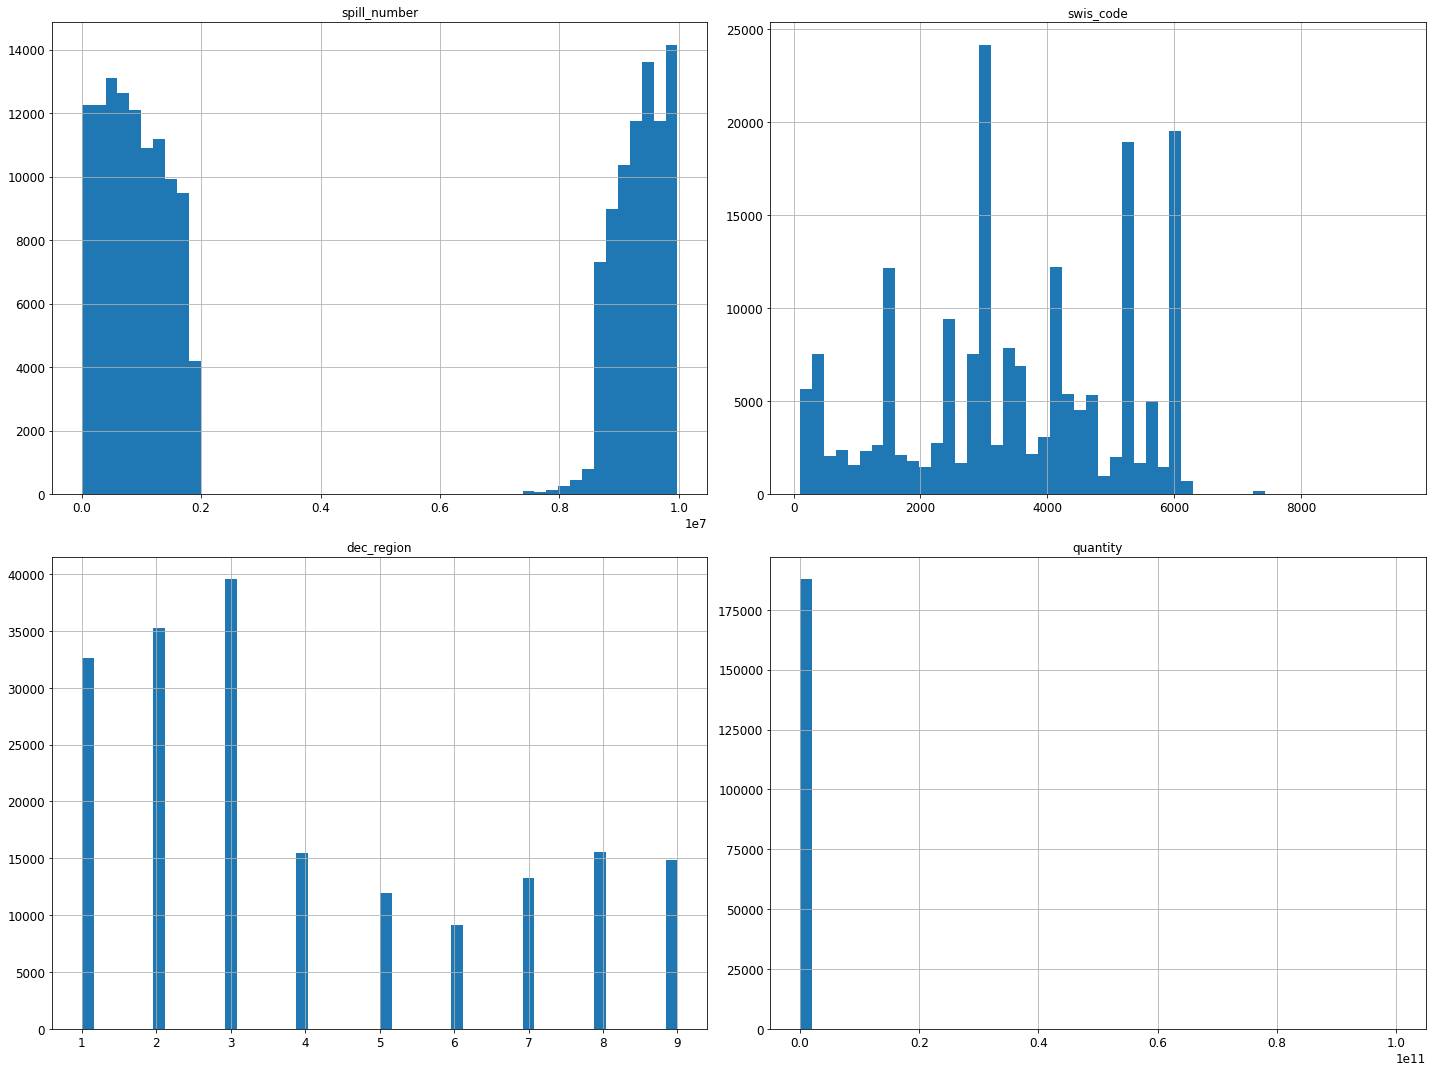

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [8]:
# to make this notebook's output identical at every run
np.random.seed(42)

#### Check correlations

In [ ]:
corr_matrix = data.corr()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

In [9]:
data.columns

Index(['spill_number', 'program_facility_name', 'street_1', 'street_2',
       'locality', 'county', 'zip_code', 'swis_code', 'dec_region',
       'spill_date', 'received_date', 'contributing_factor', 'waterbody',
       'source', 'close_date', 'material_name', 'material_family', 'quantity',
       'units', 'recovered'],
      dtype='object')

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(data, test_size=0.2, random_state=42)